In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import scipy.signal as s
from scipy.signal import find_peaks
from sklearn.metrics import adjusted_rand_score

In [2]:
# Create folder in which all figures and files are being saved
os.makedirs('Peak_Feature_Extraction', exist_ok=True)

In [3]:
#Load data
data = pd.read_csv('Data_Cleaning/dataframe_with_cluster_assignment_norm_imp.tsv', sep='\t') # add sep='\t' when dealing with a tsv file instead of a csv file
data.head() # quick overview of loaded dataset

,label,video,trace,cluster,time_10,time_20,time_30,time_40,time_50,time_60,...,time_510,time_520,time_530,time_540,time_550,time_560,time_570,time_580,time_590,time_600
0,PR8,PR8_2001,trace_089,1,0.173455,0.000000,0.064847,0.129694,0.194541,0.367129,...,0.510543,0.003033,0.364096,0.247689,0.654968,0.273830,0.431254,0.416233,0.383160,0.643847
1,X31,X31_3002,trace_013,1,0.102887,0.000000,0.075896,0.126122,0.137670,0.626574,...,0.410643,0.289878,0.083617,0.242504,0.364243,0.326122,0.199026,0.282643,0.138157,0.257043
2,X31,X31_3001,trace_033,1,0.122925,0.063706,0.104307,0.141768,0.000000,0.188425,...,0.398609,0.540377,0.576267,0.647824,0.180574,0.261552,0.484298,0.373710,0.303724,0.366083
3,X31,X31_3001,trace_032,1,0.310865,0.145652,0.004949,0.258543,0.661089,0.952392,...,0.382984,0.180061,0.091680,0.180061,0.000000,0.188074,0.631629,0.324063,0.515437,0.093095
4,X31,X31_3001,trace_018,1,0.194953,0.059148,0.117192,0.161041,0.272713,0.024132,...,0.531230,0.414038,0.328549,0.192744,0.130284,0.175237,0.250789,0.415142,0.271609,0.259621


In [4]:
# set a multi-index
data = data.set_index(['label', 'video', 'trace', 'cluster'])
data.head()

time_10   time_20   time_30   time_40  \
label video    trace     cluster                                           
PR8   PR8_2001 trace_089 1        0.173455  0.000000  0.064847  0.129694   
X31   X31_3002 trace_013 1        0.102887  0.000000  0.075896  0.126122   
      X31_3001 trace_033 1        0.122925  0.063706  0.104307  0.141768   
               trace_032 1        0.310865  0.145652  0.004949  0.258543   
               trace_018 1        0.194953  0.059148  0.117192  0.161041   

                                   time_50   time_60   time_70   time_80  \
label video    trace     cluster                                           
PR8   PR8_2001 trace_089 1        0.194541  0.367129  0.337955  0.141392   
X31   X31_3002 trace_013 1        0.137670  0.626574  0.370087  0.492313   
      X31_3001 trace_033 1        0.000000  0.188425  0.186855  0.199192   
               trace_032 1        0.661089  0.952392  0.608767  0.446618   
               trace_018 1        0.272713  0.024132  0.254101  0.089748   

                                   time_90  time_100  ...  time_510  time_520  \
label video    trace     cluster                      ...                       
PR8   PR8_2001 trace_089 1        0.205661  0.316869  ...  0.510543  0.003033   
X31   X31_3002 trace_013 1        0.291826  0.380661  ...  0.410643  0.289878   
      X31_3001 trace_033 1        0.221175  0.094886  ...  0.398609  0.540377   
               trace_032 1        0.404195  0.504124  ...  0.382984  0.180061   
               trace_018 1        0.144479  0.061356  ...  0.531230  0.414038   

                                  time_530  time_540  time_550  time_560  \
label video    trace     cluster                                           
PR8   PR8_2001 trace_089 1        0.364096  0.247689  0.654968  0.273830   
X31   X31_3002 trace_013 1        0.083617  0.242504  0.364243  0.326122   
      X31_3001 trace_033 1        0.576267  0.647824  0.180574  0.261552   
               trace_032 1        0.091680  0.180061  0.000000  0.188074   
               trace_018 1        0.328549  0.192744  0.130284  0.175237   

                                  time_570  time_580  time_590  time_600  
label video    trace     cluster                                          
PR8   PR8_2001 trace_089 1        0.431254  0.416233  0.383160  0.643847  
X31   X31_3002 trace_013 1        0.199026  0.282643  0.138157  0.257043  
      X31_3001 trace_033 1        0.484298  0.373710  0.303724  0.366083  
               trace_032 1        0.631629  0.324063  0.515437  0.093095  
               trace_018 1        0.250789  0.415142  0.271609  0.259621  

[5 rows x 60 columns]

In [5]:
# rename time columns
data.rename(columns={"time_": ""})

# For labels in the plots we need to edit the column names that are like "time_20" to "20", so we need to replace "time_" with "".
timepoints = data.columns.str.replace('time_', '')
# Convert year values to integers, saving results back to dataframe
data.columns = timepoints.astype(int)

# check
data.head()

10        20        30        40   \
label video    trace     cluster                                           
PR8   PR8_2001 trace_089 1        0.173455  0.000000  0.064847  0.129694   
X31   X31_3002 trace_013 1        0.102887  0.000000  0.075896  0.126122   
      X31_3001 trace_033 1        0.122925  0.063706  0.104307  0.141768   
               trace_032 1        0.310865  0.145652  0.004949  0.258543   
               trace_018 1        0.194953  0.059148  0.117192  0.161041   

                                       50        60        70        80   \
label video    trace     cluster                                           
PR8   PR8_2001 trace_089 1        0.194541  0.367129  0.337955  0.141392   
X31   X31_3002 trace_013 1        0.137670  0.626574  0.370087  0.492313   
      X31_3001 trace_033 1        0.000000  0.188425  0.186855  0.199192   
               trace_032 1        0.661089  0.952392  0.608767  0.446618   
               trace_018 1        0.272713  0.024132  0.254101  0.089748   

                                       90        100  ...       510       520  \
label video    trace     cluster                      ...                       
PR8   PR8_2001 trace_089 1        0.205661  0.316869  ...  0.510543  0.003033   
X31   X31_3002 trace_013 1        0.291826  0.380661  ...  0.410643  0.289878   
      X31_3001 trace_033 1        0.221175  0.094886  ...  0.398609  0.540377   
               trace_032 1        0.404195  0.504124  ...  0.382984  0.180061   
               trace_018 1        0.144479  0.061356  ...  0.531230  0.414038   

                                       530       540       550       560  \
label video    trace     cluster                                           
PR8   PR8_2001 trace_089 1        0.364096  0.247689  0.654968  0.273830   
X31   X31_3002 trace_013 1        0.083617  0.242504  0.364243  0.326122   
      X31_3001 trace_033 1        0.576267  0.647824  0.180574  0.261552   
               trace_032 1        0.091680  0.180061  0.000000  0.188074   
               trace_018 1        0.328549  0.192744  0.130284  0.175237   

                                       570       580       590       600  
label video    trace     cluster                                          
PR8   PR8_2001 trace_089 1        0.431254  0.416233  0.383160  0.643847  
X31   X31_3002 trace_013 1        0.199026  0.282643  0.138157  0.257043  
      X31_3001 trace_033 1        0.484298  0.373710  0.303724  0.366083  
               trace_032 1        0.631629  0.324063  0.515437  0.093095  
               trace_018 1        0.250789  0.415142  0.271609  0.259621  

[5 rows x 60 columns]

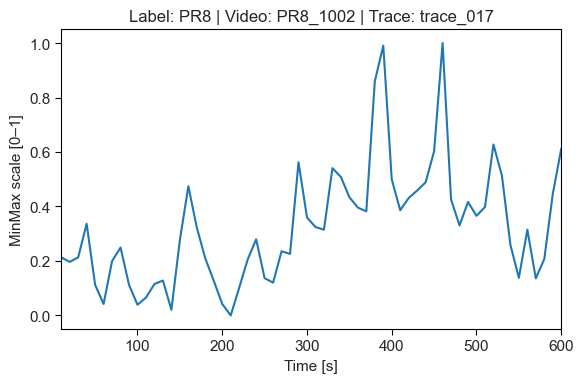

In [6]:
# --- Extract the trace ---
label = 'PR8'
video = 'PR8_1002'
trace = 'trace_017'

# Select the trace safely
trace_series = data.xs((label, video, trace), level=['label', 'video', 'trace'])
trace_series = trace_series.squeeze()  # convert to Series if only one row

# --- Determine color by strain ---
color_map = {'PR8': 'tab:blue', 'X31': 'tab:orange'}
line_color = color_map.get(label, 'black')

# --- Plot setup ---
sns.set_theme(style="white", font_scale=1, context='notebook')

fig, ax = plt.subplots(figsize=(6, 4))

# --- Plot the trace ---
ax.plot(trace_series.index.astype(float), trace_series.values, color=line_color, linewidth=1.5)
ax.set_title(f'Label: {label} | Video: {video} | Trace: {trace}', fontsize=12)
ax.set_xlabel('Time [s]', fontsize=11)
ax.set_ylabel('MinMax scale [0–1]', fontsize=11)

# --- Axis limits (tight fit, no white space) ---
ax.set_xlim(trace_series.index.min(), trace_series.index.max())

# --- Ticks: only bottom + left ---
ax.tick_params(
    axis='x', which='both',
    bottom=True, top=False,
    length=4, width=0.8, color='black'
)
ax.tick_params(
    axis='y', which='both',
    left=True, right=False,
    length=4, width=0.8, color='black'
)

# --- Black frame around plot ---
for spine in ax.spines.values():
    spine.set_visible(True)
    spine.set_color('black')
    spine.set_linewidth(0.8)

# --- Transparent background ---
fig.patch.set_alpha(0)
ax.set_facecolor('none')

plt.tight_layout()
plt.show()

In [7]:
# Reset the 'cluster' level frothe index
data = data.reset_index(level='cluster')

# Move 'cluster' to the last column
# First, remove it and re-insert it at the end
cluster_col = data.pop('cluster')
data['cluster'] = cluster_col

In [8]:
data['signal_cluster'] = data['cluster'].apply(lambda x: x in {1, 2, 4, 5, 6, 7})

In [9]:
data

10        20        30        40        50  \
label video    trace                                                         
PR8   PR8_2001 trace_089  0.173455  0.000000  0.064847  0.129694  0.194541   
X31   X31_3002 trace_013  0.102887  0.000000  0.075896  0.126122  0.137670   
      X31_3001 trace_033  0.122925  0.063706  0.104307  0.141768  0.000000   
               trace_032  0.310865  0.145652  0.004949  0.258543  0.661089   
               trace_018  0.194953  0.059148  0.117192  0.161041  0.272713   
...                            ...       ...       ...       ...       ...   
PR8   PR8_1002 trace_061  0.483193  0.033013  0.629052  0.075030  0.108043   
      PR8_5003 trace_015  0.351453  0.251796  0.451109  0.650734  0.505467   
      PR8_4003 trace_034  0.728346  0.591078  0.538641  0.542347  0.358408   
      PR8_4002 trace_095  0.281214  0.390125  0.663366  0.442844  0.473190   
      PR8_5003 trace_031  0.667643  0.796486  0.586628  0.600293  0.806735   

                                60        70        80        90       100  \
label video    trace                                                         
PR8   PR8_2001 trace_089  0.367129  0.337955  0.141392  0.205661  0.316869   
X31   X31_3002 trace_013  0.626574  0.370087  0.492313  0.291826  0.380661   
      X31_3001 trace_033  0.188425  0.186855  0.199192  0.221175  0.094886   
               trace_032  0.952392  0.608767  0.446618  0.404195  0.504124   
               trace_018  0.024132  0.254101  0.089748  0.144479  0.061356   
...                            ...       ...       ...       ...       ...   
PR8   PR8_1002 trace_061  0.870948  0.337335  0.445978  0.166267  0.178872   
      PR8_5003 trace_015  0.577007  0.297095  0.572634  0.390503  0.466417   
      PR8_4003 trace_034  0.497598  0.993274  0.550995  0.559506  0.851201   
      PR8_4002 trace_095  0.535682  0.623248  0.729459  0.617847  0.504436   
      PR8_5003 trace_031  0.783309  0.298682  0.803319  0.966325  0.637384   

                          ...       530       540       550       560  \
label video    trace      ...                                           
PR8   PR8_2001 trace_089  ...  0.364096  0.247689  0.654968  0.273830   
X31   X31_3002 trace_013  ...  0.083617  0.242504  0.364243  0.326122   
      X31_3001 trace_033  ...  0.576267  0.647824  0.180574  0.261552   
               trace_032  ...  0.091680  0.180061  0.000000  0.188074   
               trace_018  ...  0.328549  0.192744  0.130284  0.175237   
...                       ...       ...       ...       ...       ...   
PR8   PR8_1002 trace_061  ...  0.554022  0.228691  0.950180  0.729292   
      PR8_5003 trace_015  ...  0.316776  0.268978  0.227741  0.388316   
      PR8_4003 trace_034  ...  0.193548  0.313658  0.395607  0.418531   
      PR8_4002 trace_095  ...  0.493764  0.113411  0.229394  0.083065   
      PR8_5003 trace_031  ...  0.928746  0.562714  0.654466  0.454368   

                               570       580       590       600  cluster  \
label video    trace                                                        
PR8   PR8_2001 trace_089  0.431254  0.416233  0.383160  0.643847        1   
X31   X31_3002 trace_013  0.199026  0.282643  0.138157  0.257043        1   
      X31_3001 trace_033  0.484298  0.373710  0.303724  0.366083        1   
               trace_032  0.631629  0.324063  0.515437  0.093095        1   
               trace_018  0.250789  0.415142  0.271609  0.259621        1   
...                            ...       ...       ...       ...      ...   
PR8   PR8_1002 trace_061  0.637455  0.662665  0.487395  0.904562        9   
      PR8_5003 trace_015  0.093408  0.407998  0.333958  0.388316        9   
      PR8_4003 trace_034  0.470007  0.757859  0.891283  0.441318        9   
      PR8_4002 trace_095  0.016073  0.216922  0.136557  0.000000        9   
      PR8_5003 trace_031  0.654466  0.657882  0.661298  0.860908        9   

                          signal_cluster  
label v

In [10]:
# Select only the signal columns (e.g., "0", "10", ..., "600")
signal_columns = [col for col in data.columns if str(col).isdigit()]
# Sum across time points (i.e., across the row)
data["cum_sum"] = data[signal_columns].sum(axis=1)
data["signal_cum_sum"] = data["cum_sum"] < 28.17
data

10        20        30        40        50  \
label video    trace                                                         
PR8   PR8_2001 trace_089  0.173455  0.000000  0.064847  0.129694  0.194541   
X31   X31_3002 trace_013  0.102887  0.000000  0.075896  0.126122  0.137670   
      X31_3001 trace_033  0.122925  0.063706  0.104307  0.141768  0.000000   
               trace_032  0.310865  0.145652  0.004949  0.258543  0.661089   
               trace_018  0.194953  0.059148  0.117192  0.161041  0.272713   
...                            ...       ...       ...       ...       ...   
PR8   PR8_1002 trace_061  0.483193  0.033013  0.629052  0.075030  0.108043   
      PR8_5003 trace_015  0.351453  0.251796  0.451109  0.650734  0.505467   
      PR8_4003 trace_034  0.728346  0.591078  0.538641  0.542347  0.358408   
      PR8_4002 trace_095  0.281214  0.390125  0.663366  0.442844  0.473190   
      PR8_5003 trace_031  0.667643  0.796486  0.586628  0.600293  0.806735   

                                60        70        80        90       100  \
label video    trace                                                         
PR8   PR8_2001 trace_089  0.367129  0.337955  0.141392  0.205661  0.316869   
X31   X31_3002 trace_013  0.626574  0.370087  0.492313  0.291826  0.380661   
      X31_3001 trace_033  0.188425  0.186855  0.199192  0.221175  0.094886   
               trace_032  0.952392  0.608767  0.446618  0.404195  0.504124   
               trace_018  0.024132  0.254101  0.089748  0.144479  0.061356   
...                            ...       ...       ...       ...       ...   
PR8   PR8_1002 trace_061  0.870948  0.337335  0.445978  0.166267  0.178872   
      PR8_5003 trace_015  0.577007  0.297095  0.572634  0.390503  0.466417   
      PR8_4003 trace_034  0.497598  0.993274  0.550995  0.559506  0.851201   
      PR8_4002 trace_095  0.535682  0.623248  0.729459  0.617847  0.504436   
      PR8_5003 trace_031  0.783309  0.298682  0.803319  0.966325  0.637384   

                          ...       550       560       570       580  \
label video    trace      ...                                           
PR8   PR8_2001 trace_089  ...  0.654968  0.273830  0.431254  0.416233   
X31   X31_3002 trace_013  ...  0.364243  0.326122  0.199026  0.282643   
      X31_3001 trace_033  ...  0.180574  0.261552  0.484298  0.373710   
               trace_032  ...  0.000000  0.188074  0.631629  0.324063   
               trace_018  ...  0.130284  0.175237  0.250789  0.415142   
...                       ...       ...       ...       ...       ...   
PR8   PR8_1002 trace_061  ...  0.950180  0.729292  0.637455  0.662665   
      PR8_5003 trace_015  ...  0.227741  0.388316  0.093408  0.407998   
      PR8_4003 trace_034  ...  0.395607  0.418531  0.470007  0.757859   
      PR8_4002 trace_095  ...  0.229394  0.083065  0.016073  0.216922   
      PR8_5003 trace_031  ...  0.654466  0.454368  0.654466  0.657882   

                               590       600  cluster  signal_cluster  \
label video    trace                                                    
PR8   PR8_2001 trace_089  0.383160  0.643847        1            True   
X31   X31_3002 trace_013  0.138157  0.257043        1            True   
      X31_3001 trace_033  0.303724  0.366083        1            True   
               trace_032  0.515437  0.093095        1            True   
               trace_018  0.271609  0.259621        1            True   
...                            ...       ...      ...             ...   
PR8   PR8_1002 trace_061  0.487395  0.904562        9           False   
      PR8_5003 trace_015  0.333958  0.388316        9           False   
      PR8_4003 trace_034  0.891283  0.441318        9           False   
      PR8_4002 trace_095  0.136557  0.000000        9           False   
      PR8_5003 trace_031  0.661298  0.860908        9           False   

                            cum_sum  signal_cum_sum  
label video    trace                            

In [11]:
def run_peak_feature_extraction(
    data: pd.DataFrame,
    all_cols,
    test_name="testx",
    height=0.0,
    prominence=0.0,
    width=0.0,
    distance=3,
    min_high_peaks=4,
    high_peak_threshold=0.7,
    random_seed=42,
    n_samples_total=10,
    dateiname="Peak_Feature_Extraction"
):
    """Complete pipeline for peak feature extraction, sampling, and visualization."""

    # --- Session flag handling ---
    global _peak_session_initialized
    if "_peak_session_initialized" not in globals():
        print("Initializing new peak feature extraction session...")
        _peak_session_initialized = True

        combined_file = os.path.join(dateiname, "combined_signal_output.tsv")
        if os.path.exists(combined_file):
            os.remove(combined_file)
            print("Deleted old combined_signal_output.tsv for a clean start.")

    # --- Ensure output directory exists ---
    os.makedirs(dateiname, exist_ok=True)

    print(f"\n=== Running Peak Feature Extraction: {test_name} ===")
    np.random.seed(random_seed)

    # --- Step 1: Detect peaks ---
    all_peaks = []
    peak_counts = {}
    background_flags = {}

    # ensure columns are in numeric/time order
    all_cols = sorted(all_cols)
    for idx, row in data.iterrows():
        # ensure numeric array (protect against object dtype)
        trace = row[all_cols].to_numpy(dtype=float, copy=False)

        # match old call exactly: height=0, prominence=0, width=0, distance=3 (defaulted above)
        peaks, properties = find_peaks(
            trace,
            height=height,
            prominence=prominence,
            width=width,
            distance=distance
        )

        peak_heights = properties.get("peak_heights", np.array([]))
        num_high_peaks = int(np.sum(peak_heights > high_peak_threshold))
        
        # --- Flexible classification logic ---
        # Count how many peaks are above the height threshold
        peak_heights = properties.get("peak_heights", np.array([]))
        num_high_peaks = int(np.sum(peak_heights > high_peak_threshold))
        
        # If min_high_peaks > 0, use the strict rule:
        # background if there are at least that many high peaks
        if min_high_peaks > 0:
            is_background = num_high_peaks >= min_high_peaks
        else:
            # Otherwise, background if there are no peaks at all
            is_background = len(peaks) == 0

        all_peaks.append({
            "trace_index": idx,
            "peak_indices": peaks,
            "peak_heights": peak_heights,
            "prominences": properties.get("prominences", None),
            "is_background": is_background,
        })

        peak_counts[idx] = len(peaks)
        background_flags[idx] = is_background

    num_background = int(np.sum(list(background_flags.values())))
    num_traces_with_peaks = sum(len(x["peak_indices"]) > 0 for x in all_peaks)
    print(f"Background traces: {num_background}")
    print(f"Traces with peaks: {num_traces_with_peaks}")

    if num_traces_with_peaks == 0:
        print("No peaks detected — try lowering height/prominence or threshold.")
        return data, None, all_peaks

    # --- Step 2: Build peak feature DataFrame ---
    df = pd.DataFrame.from_dict(peak_counts, orient="index").reset_index(names="ix")
    df["is_background"] = df["ix"].map(background_flags)
    df[["label", "video", "trace"]] = pd.DataFrame(df["ix"].tolist(), index=df.index)
    df = df.drop(columns=["ix"]).set_index(["label", "video", "trace"])

    num_col = f"num_peaks_{test_name}"
    signal_col = f"signal_peaks_{test_name}"
    df = df.rename(columns={0: num_col})
    # signal = NOT background (same as your old step 3)
    df[signal_col] = ~df["is_background"]
    df = df[[num_col, signal_col]]

    # --- Step 3: Merge into main dataset ---
    df = df.reindex(data.index)
    data[num_col] = df[num_col]
    data[signal_col] = df[signal_col]

    # --- Step 4: Load previous results (and merge safely) ---
    combined_file = os.path.join(dateiname, "combined_signal_output.tsv")
    if os.path.exists(combined_file):
        old_data = pd.read_csv(combined_file, sep="\t", index_col=[0, 1, 2])
        old_cols = [c for c in old_data.columns if c not in data.columns]
        if old_cols:
            data = data.join(old_data[old_cols], how="outer")

    # --- Step 5: Plot random trace visualization ---
    labels = data.index.get_level_values("label")
    pr8_idx = [i for i, p in enumerate(all_peaks) if labels[i] == "PR8" and len(p["peak_indices"]) > 0]
    x31_idx = [i for i, p in enumerate(all_peaks) if labels[i] == "X31" and len(p["peak_indices"]) > 0]
    
    n_pr8 = min(len(pr8_idx), n_samples_total // 2)
    n_x31 = min(len(x31_idx), n_samples_total - n_pr8)
    if n_pr8 + n_x31 == 0:
        print("No traces with peaks to visualize.")
        return data, df, all_peaks
    
    sampled_pr8 = np.random.choice(pr8_idx, size=n_pr8, replace=False) if n_pr8 > 0 else []
    sampled_x31 = np.random.choice(x31_idx, size=n_x31, replace=False) if n_x31 > 0 else []
    random_positions = np.concatenate([sampled_pr8, sampled_x31])
    np.random.shuffle(random_positions)
    
    time = [float(t) for t in all_cols]
    color_map = {"PR8": "tab:blue", "X31": "tab:orange"}
    
    fig, axes = plt.subplots(5, 2, figsize=(14, 12))
    axes = axes.flatten()

    for i, pos in enumerate(random_positions[:10]):
        row = data.iloc[pos]
        label, video, trace_name = row.name
        trace = row[all_cols].values
        peaks = all_peaks[pos]["peak_indices"]
        color = color_map.get(label, "black")
    
        ax = axes[i]
        ax.plot(time, trace, color=color, linewidth=1.5)
        ax.plot([time[p] for p in peaks], trace[peaks], "ro", markersize=4)
        ax.set_title(f"Label: {label} | Video: {video} | Trace: {trace_name}", fontsize=9)
        ax.tick_params(axis="x", bottom=True, top=False)
        ax.tick_params(axis="y", left=True, right=False)
    
        # Remove whitespace at beginning and end
        ax.set_xlim(time[0], time[-1])
    
        # Clean up subplot borders
        for spine in ax.spines.values():
            spine.set_visible(True)
            spine.set_linewidth(0.8)
            spine.set_color("black")
    
    # Add y-axis labels (one per row on the left)
    for i in range(0, len(axes), 2):
        axes[i].set_ylabel("MinMax scale", fontsize=11)
    
    # Add x-axis labels (bottom row only)
    for ax in axes[-2:]:
        ax.set_xlabel("Time [s]", fontsize=11)
    
    plt.tight_layout(rect=[0.02, 0.02, 0.98, 0.98])
    plt.savefig(os.path.join(dateiname, f"Subplots.png"), dpi=300, bbox_inches="tight")
    plt.show()

    
    # --- Step 6: Partitioning heatmap (include all tests) ---
    base_methods = ["signal_cluster", "signal_cum_sum"]
    signal_tests = [c for c in data.columns if isinstance(c, str) and c.startswith("signal_peaks_")]
    methods = [m for m in base_methods if m in data.columns] + signal_tests
    
    data_sorted = data.sort_values("cluster").reset_index(drop=True)
    plot_matrix = data_sorted[methods].astype(int).T
    
    fig, ax = plt.subplots(figsize=(15, max(4, len(methods) * 0.3)))
    cax = ax.matshow(plot_matrix, cmap="viridis_r", aspect="auto", vmin=0, vmax=1)
    ax.set_yticks(range(len(methods)))
    ax.set_yticklabels(methods)
    ax.set_xlabel("Sample index (sorted by cluster)")
    ax.set_title("Signal vs. Background Partitioning per Method")
    ax.xaxis.set_ticks_position("bottom")
    fig.colorbar(cax, label="0 = Background | 1 = Signal")
    plt.tight_layout()
    plt.savefig(os.path.join(dateiname, f"Partitioning_heatmap.png"), dpi=300, bbox_inches="tight")
    plt.show()
    
    
    # --- Step 7: ARI Matrix ---
    signal_cols = [c for c in data.columns if isinstance(c, str) and c.startswith("signal_")]
    n = len(signal_cols)
    ari_matrix = np.zeros((n, n))
    for i, c1 in enumerate(signal_cols):
        for j, c2 in enumerate(signal_cols):
            ari_matrix[i, j] = adjusted_rand_score(data[c1].astype(int), data[c2].astype(int))
    
    fig, ax = plt.subplots(figsize=(max(8, n * 0.5), max(7, n * 0.5)))
    sns.heatmap(
        ari_matrix,
        xticklabels=signal_cols,
        yticklabels=signal_cols,
        annot=True,
        fmt=".2f",
        cmap="plasma",
        vmin=0, vmax=1,
        linewidths=0.5,
        linecolor="white",
        cbar=True,
        ax=ax,
    )
    
    # Add black outline around the colorbar
    cbar = ax.collections[0].colorbar
    for spine in cbar.ax.spines.values():
        spine.set_edgecolor("black")
        spine.set_linewidth(1.2)
    
    # Add black border around the heatmap
    for spine in ax.spines.values():
        spine.set_visible(True)
        spine.set_edgecolor("black")
        spine.set_linewidth(1.2)
    
    # Add axis ticks
    ax.set_xticks(np.arange(len(signal_cols)) + 0.5)
    ax.set_yticks(np.arange(len(signal_cols)) + 0.5)
    ax.tick_params(axis="x", bottom=True, top=False, labelrotation=90, labelsize=9)
    ax.tick_params(axis="y", left=True, right=False, labelrotation=0, labelsize=9)
    
    ax.set_xlabel("Signal Detection Method", fontsize=12)
    ax.set_ylabel("Signal Detection Method", fontsize=12)
    ax.set_title("Adjusted Rand Index between signal detection methods", fontsize=14, pad=15)
    
    plt.tight_layout()
    plt.savefig(os.path.join(dateiname, f"ARI_matrix.png"), dpi=300, bbox_inches="tight")
    plt.show()
    
    
    # --- Step 8: Save updated combined results ---
    data.to_csv(os.path.join(dateiname, "combined_signal_output.tsv"), sep="\t", index=True)

    return data, df, all_peaks

Initializing new peak feature extraction session...
Deleted old combined_signal_output.tsv for a clean start.

=== Running Peak Feature Extraction: test2 ===
Background traces: 806
Traces with peaks: 2825


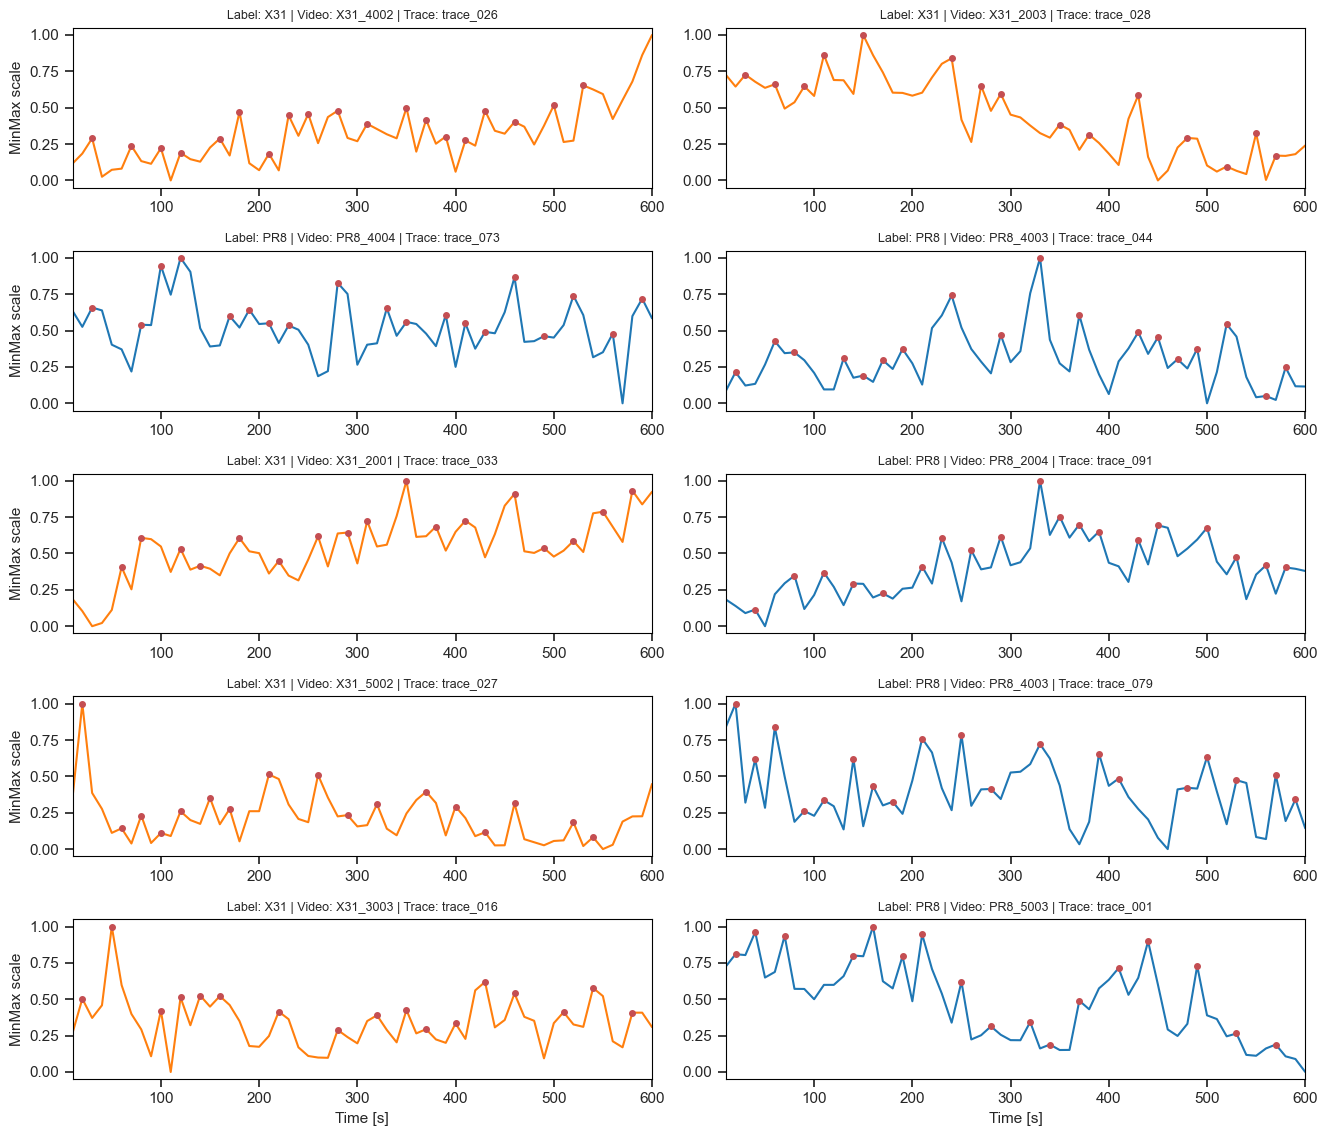

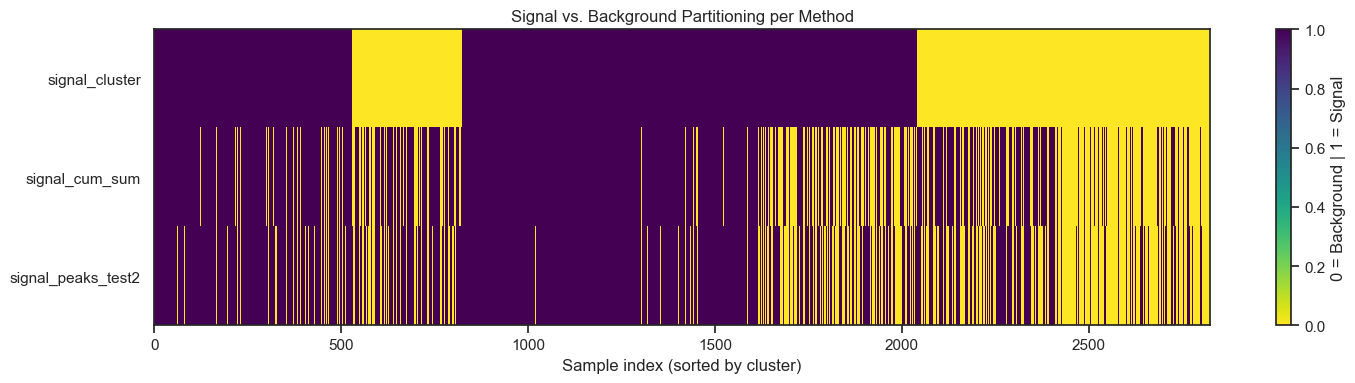

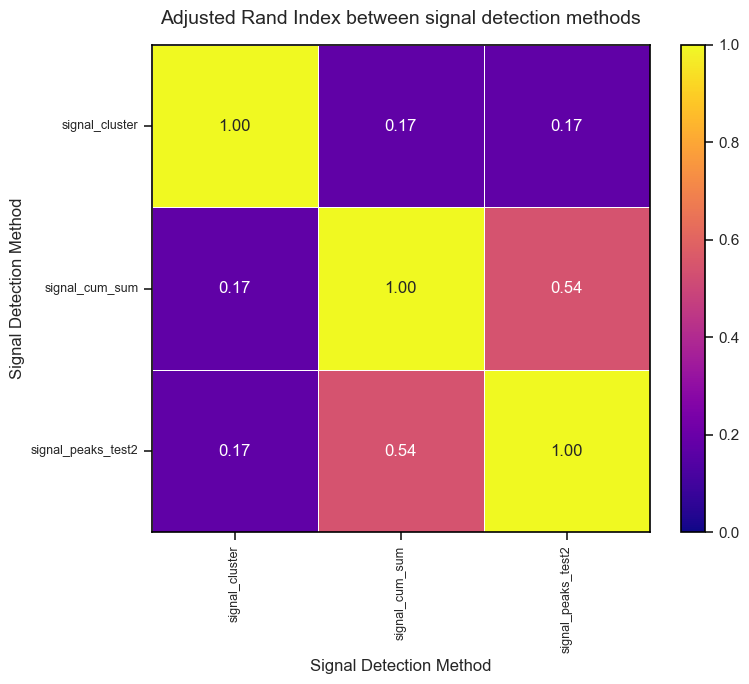

In [12]:
time_cols = [col for col in data.columns if isinstance(col, int)]
time_cols = sorted(time_cols)

data, df, all_peaks = run_peak_feature_extraction(
    data=data,
    all_cols=time_cols,
    test_name="test2",
    height=0,
    prominence=0,
    width=0,
    distance=1,
    min_high_peaks=7,
    high_peak_threshold=0.7
)

    test_name="test",
    height=0.8,
    prominence=0.6,
    width=(2,6),
    distance=1,
    min_high_peaks=0,
    high_peak_threshold=0
    
    test_name="test1",
    height=0,
    prominence=0.6,
    width=(2,6),
    distance=1,
    min_high_peaks=0,
    high_peak_threshold=0

    test_name="test2",
    height=0,
    prominence=0.6,
    width=(2,6),
    distance=1,
    min_high_peaks=5,
    high_peak_threshold=0.7,

    test_name="test3",
    height=0,
    prominence=0,
    width=0,
    distance=1,
    min_high_peaks=5,
    high_peak_threshold=0.7,

    test_name="test4",
    height=0,
    prominence=0,
    width=0,
    distance=1,
    min_high_peaks=7,
    high_peak_threshold=0.7,

    test_name="test5",
    height=0,
    prominence=0,
    width=0,
    distance=3,
    min_high_peaks=5,
    high_peak_threshold=0.6,

    test_name="test6",
    height=0,
    prominence=0,
    width=0,
    distance=2,
    min_high_peaks=8,
    high_peak_threshold=0.7,

    test_name="test7",
    height=0,
    prominence=0,
    width=0,
    distance=2,
    min_high_peaks=7,
    high_peak_threshold=0.65,

    test_name="test8",
    height=0,
    prominence=0.6,
    width=(1,3),
    distance=2,
    min_high_peaks=0,
    high_peak_threshold=0,

In [13]:
import sys
sys.exit()

SystemExit: 

C:\Users\dlu25\Anaconda\Lib\site-packages\IPython\core\interactiveshell.py:3585: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [ ]:
import os

def reset_peak_tests(data, dateiname="Peak_Feature_Extraction"):
    """
    Completely resets all test-based columns and session state,
    but keeps core signal columns like 'signal_cluster' and 'signal_cum_sum'.
    """
    global _peak_session_initialized

    # --- 1️. Remove session flag ---
    if "_peak_session_initialized" in globals():
        del _peak_session_initialized
        print("Kernel session flag deleted.")

    # --- 2️. Delete combined file on disk ---
    combined_file = os.path.join(dateiname, "combined_signal_output.tsv")
    if os.path.exists(combined_file):
        os.remove(combined_file)
        print("Deleted old combined_signal_output.tsv file.")
    else:
        print("No combined_signal_output.tsv file found.")

    # --- 3️. Remove only peak test columns from DataFrame ---
    keep_cols = {"signal_cluster", "signal_cum_sum"}
    drop_cols = [
        c for c in data.columns
        if isinstance(c, str)
        and (c.startswith("signal_") or c.startswith("num_peaks_"))
        and c not in keep_cols
    ]

    if drop_cols:
        data = data.drop(columns=drop_cols)
        print(f"Removed {len(drop_cols)} old test columns from DataFrame.")
    else:
        print("No test columns to remove.")

    print("Full reset complete — core methods retained.")
    return data

# Example usage:
data = reset_peak_tests(data, "Peak_Feature_Extraction")

In [ ]:
# Call function with:
data = reset_peak_tests(data, "Peak_Feature_Extraction")

In [ ]:
# --- Step 1: Reload saved combined dataset ---
data = pd.read_csv(
    "Peak_Feature_Extraction/combined_signal_output.tsv",
    sep="\t",
    index_col=[0, 1, 2]
)

# --- Step 2: Rebuild the time columns (for plotting) ---
time_cols = [col for col in data.columns if isinstance(col, int)]
time_cols = sorted(time_cols)

# --- Step 3: Call the function with `data` as input again ---
data, df, all_peaks = run_peak_feature_extraction(
    data=data,
    all_cols=time_cols,
    test_name="test1",
    height=0.0,
    prominence=0.00,
    width=0,
    distance=1,
    min_high_peaks=4,
    dateiname="Peak_Feature_Extraction"
)